# Generating Movement Sequences with LSTM

In this model we are using a recording of a short dance impovisation, captured by [PoseNet](https://blog.tensorflow.org/2018/05/real-time-human-pose-estimation-in.html) with x and y coordinate values for 13 body joints:
- nose,
- leftShoulder, rightShoulder
- leftElbow, rightElbow
- leftWrist, rightWrist
- leftHip, rightHip
- leftKnee, rightKnee
- leftAnkle, rightAnkle

This is our training dataset (35381 dataframes) for generating new sequences of movements.

Coded by Daniel Berio and Irini Kalaitzidi

Ref: [MDN-RNN-kanji-generation-example.ipynb](https://github.com/cpmpercussion/keras-mdn-layer/blob/master/notebooks/MDN-RNN-kanji-generation-example.ipynb)

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import mdn
import random
import tensorflow as tf

In [2]:
# Reading (x,y) coordinates of 13 joints captured during pose detection
df = pd.read_csv('sample_dataset.csv')
df.head(5)

,milliseconds,noseX,noseY,leftShoulderX,leftShoulderY,rightShoulderX,rightShoulderY,leftElbowX,leftElbowY,rightElbowX,...,rightHipX,rightHipY,leftKneeX,leftKneeY,rightKneeX,rightKneeY,leftAnkleX,leftAnkleY,rightAnkleX,rightAnkleY
0,98.0,321.0,124.0,343.0,161.0,289.0,170.0,375.0,163.0,283.0,...,293.0,255.0,312.0,325.0,280.0,317.0,321.0,390.0,283.0,354.0
1,148.0,326.0,124.0,349.0,159.0,294.0,164.0,373.0,176.0,296.0,...,297.0,247.0,316.0,319.0,298.0,309.0,327.0,370.0,310.0,370.0
2,198.0,332.0,127.0,348.0,160.0,302.0,161.0,376.0,175.0,306.0,...,302.0,245.0,327.0,335.0,314.0,316.0,326.0,388.0,311.0,387.0
3,248.0,339.0,121.0,350.0,160.0,310.0,156.0,367.0,183.0,322.0,...,306.0,246.0,330.0,334.0,318.0,311.0,324.0,370.0,321.0,373.0
4,298.0,339.0,121.0,350.0,160.0,310.0,156.0,367.0,183.0,322.0,...,306.0,246.0,330.0,334.0,318.0,311.0,324.0,370.0,321.0,373.0


In [3]:
# Size of our dataset
df.shape

(35381, 27)

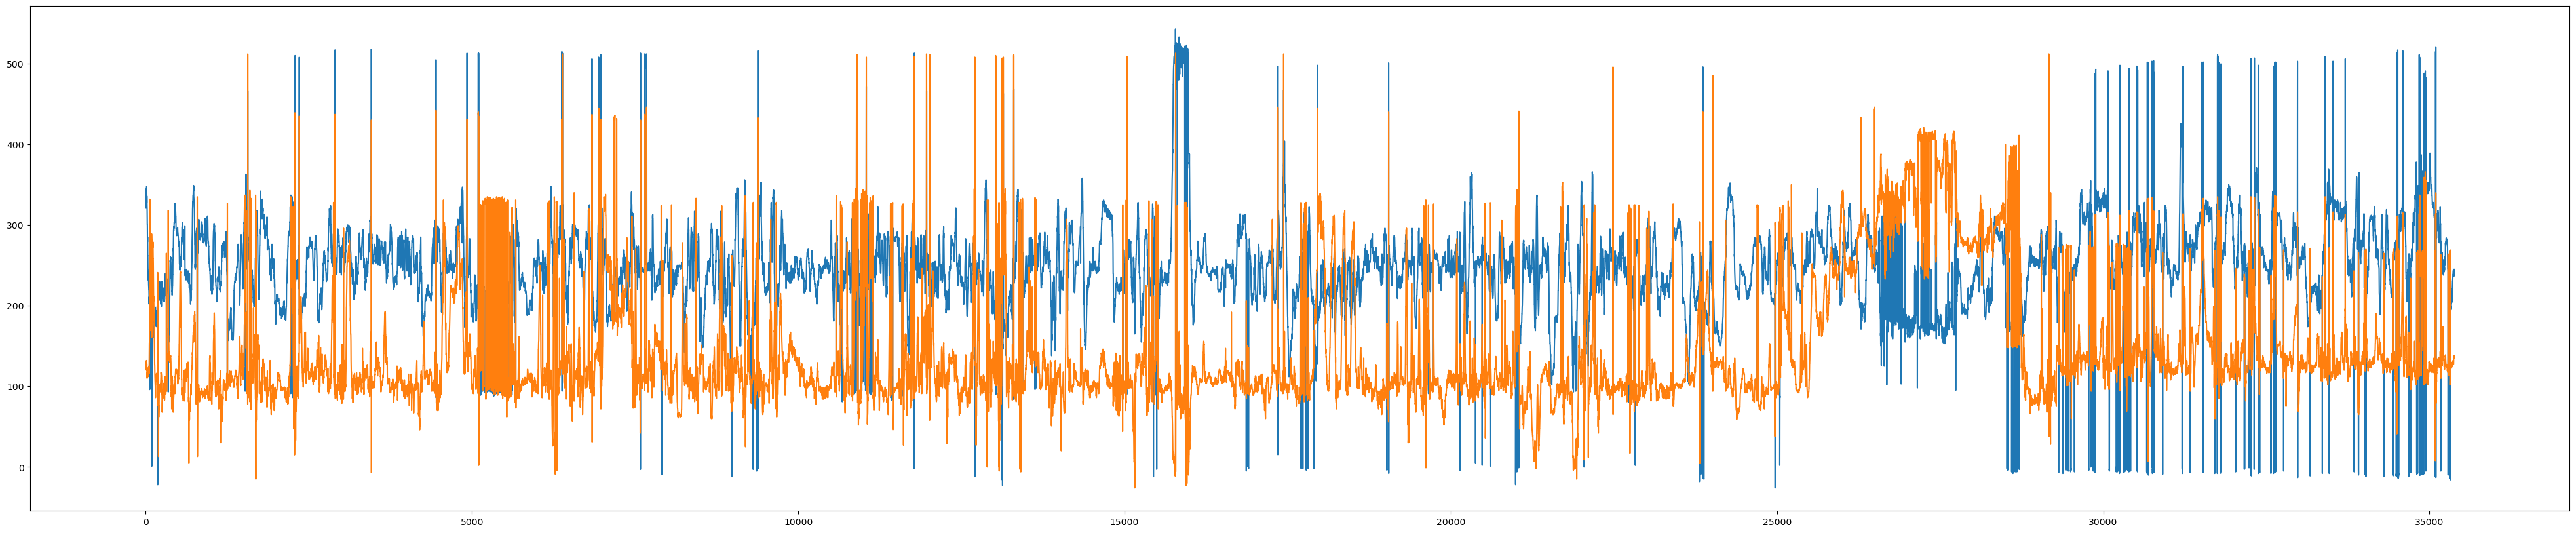

In [4]:
# Plotting the change of coordinates values for 1 body joint, e.g. the nose
plt.figure(figsize=(50, 10))

plt.plot(df['noseX']) #blue line
plt.plot(df['noseY']) #orange line

plt.show()

In [5]:
# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

In [6]:
# Turning our dataframe structure into an array, excluding the first column of the milliseconds
seq = np.array(df.iloc[:35381,1:])

# Normalising our data with min max
sc = MinMaxScaler()
seq = sc.fit_transform(seq)

# Defining and using our window size to create our inputs X and outputs y
SEQ_LEN = 50
slices = slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_singleton_format(slices)

X = np.array(X)
y = np.array(y)

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

Number of training examples:
X: (35329, 50, 26)
y: (35329, 26)


In [10]:
# Splitting training and testing data from the total of 35381
X_train, y_train = X[:30000], y[:30000]
X_test, y_test = X[30000:], y[30000:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30000, 50, 26), (30000, 26), (5329, 50, 26), (5329, 26))

# Building our Model

In [11]:
# Training Hyperparameters:
BATCH_SIZE = 64
HIDDEN_UNITS = 128 #256
EPOCHS = 2 #100
OUTPUT_DIMENSION = 26 # the number of coordinates
NUMBER_MIXTURES = 10

# Sequential model
model = Sequential()

# Add two LSTM layers, make sure the input shape of the first one is (?, fit into any sequence length?, 26)
model.add(LSTM(HIDDEN_UNITS, batch_input_shape=(None,None,OUTPUT_DIMENSION), return_sequences=True))
model.add(LSTM(HIDDEN_UNITS))

# Here's the MDN layer, need to specify the output dimension (26) and number of mixtures (10)
model.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))

# If you did not want to use an MDN, you could instead add a Dense Layer
# model.add(Dense(26))

# Now we compile the MDN RNN - need to use a special loss function with the right number of dimensions and mixtures.
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer='adam')

# This compiler would be used if we only used a Dense layer instead of the MDN
# model.compile(optimizer='adam', loss='mean_squared_error')

# Let's see what we have:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 128)         79360     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 mdn_1 (MDN)                 (None, 530)               68370     
                                                                 
Total params: 279,314
Trainable params: 279,314
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Fit the model
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/2


2023-02-06 20:45:03.957227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-06 20:45:04.500718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-06 20:45:04.571808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-06 20:45:05.099987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-06 20:45:05.229347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


553/553 [==============================] - 34s 55ms/step - loss: -36.2497
Epoch 2/2
553/553 [==============================] - 29s 53ms/step - loss: -45.7431


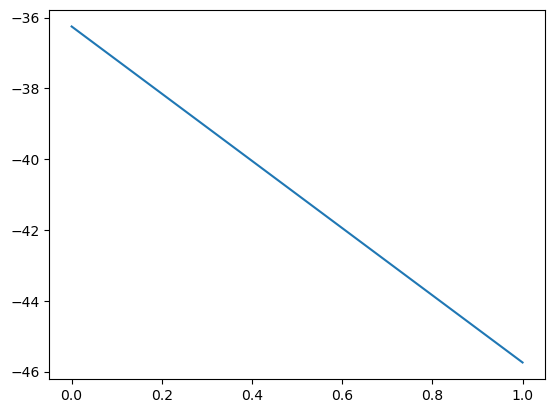

In [13]:
# Plot our loss
plt.figure()
plt.plot(history.history['loss'])
plt.show()

In [14]:
X_test.shape

(5329, 50, 26)

In [16]:
# Version 1
# Priming as if saying "get inspiration from" these many inputs, it gives it from context 
# Imagine that it has been trained on approx 1h of dancing
# This is tell it to use inspiration from a specific part
def prime_model(input):
    pred = model.predict(tf.expand_dims(input, axis=0))
    
# Predicting for a sequence of frames, p is the starting point, length the number of frames
def predict_sequence(p, length, temp=2.5, sigma_temp=0.1):
    result = [p.reshape(1,26)]
    for i in range(length):
        pred = model.predict(p.reshape(1,1,26))
        p = mdn.sample_from_output(pred[0], 26, NUMBER_MIXTURES, temp=temp, sigma_temp=sigma_temp)
        result.append(p)
    return tf.concat(result, axis=0)

model.reset_states()
prime_model(X_test[0][:4]) # prime model with the first 4 points
pred = predict_sequence(X_test[0][4], 50) #start from point 4 and predict for 50 more
pred.shape

1/1 [==============================] - 0s 13ms/step


TensorShape([51, 26])

In [17]:
# Reversing the normalisation we did before the training
pred_f = sc.inverse_transform(pred)

# Storing predictions in a dataframe
df_f = pd.DataFrame(pred_f)

pred_f.shape

(51, 26)

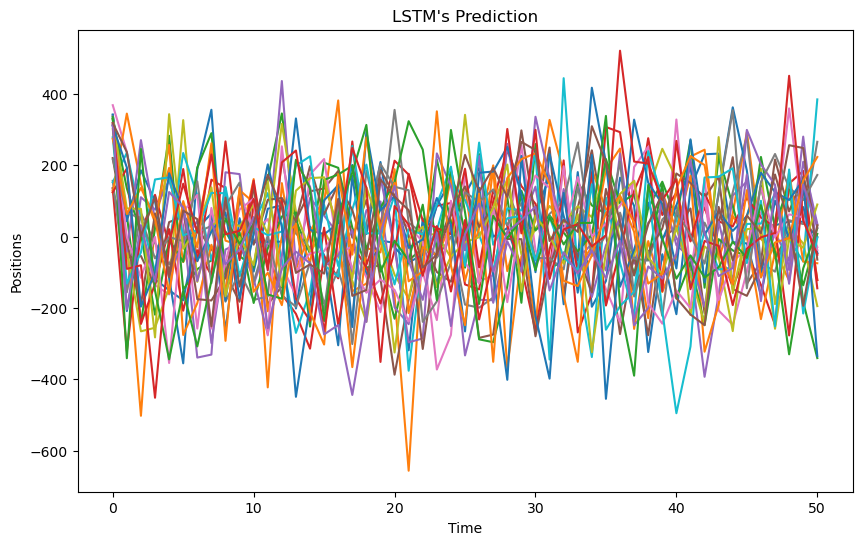

In [18]:
# Plotting the predicted/generated coordinates
plt.figure(figsize=(10, 6))
plt.plot(pred_f, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Time')
plt.ylabel('Positions')
plt.show();

In [19]:
#Saving dataframes to a csv file to visuale later with a seperate notebook
df_f.to_csv('pred_values.csv')